# Proyecto de series de tiempo univariadas (Red Neuronal Recurrente)
El siguiente Script abarca la modelación del PIB en Colombia; desde enero de 2005 hasta diciembre de 2023; utilizando redes neuronales recurrentes
## Integrantes: Anderson Guarín, Ander Cristancho, Juan Duitama

## Librerías utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import tensorflow.keras as keras

## Importación datos

In [2]:
import os
#Directorio Anderson
os.chdir(r"C:\Users\ander\OneDrive - Universidad Nacional de Colombia\Documentos\(2024-01) Octavo Semestre\Series de Tiempo Univariadas\Proyecto")
#Directorio Duitama
#os.chdir("D:\Estadística\Semestres\Semestre 9\Series de Tiempo Univariadas\Datos")
#Directorio Ander
#os.chdir(r"C:\Users\EQUIPO\OneDrive\Documentos\Documentos Ander\UNAL\Series de tiempo\Mis series y descriptiva")
os.getcwd()

'C:\\Users\\ander\\OneDrive - Universidad Nacional de Colombia\\Documentos\\(2024-01) Octavo Semestre\\Series de Tiempo Univariadas\\Proyecto'

In [55]:
DatosPIB = pd.read_excel("PIB.xlsx",skiprows=16,nrows=77)
DatosPIB = DatosPIB.iloc[:,[0,44]]
print(DatosPIB.dtypes)
# Cambiar los nombres de las columnas
col_names = ['Anio-Trimestre','PIB']
DatosPIB.columns = col_names
# Uso de nuevo df
DatosPIB['Anio-Trimestre'] = DatosPIB['Anio-Trimestre'].astype(str)
DatosPIB['Anio-Trimestre']=DatosPIB['Anio-Trimestre'].str[:4] + '-' + DatosPIB['Anio-Trimestre'].str[4:]
# Mapeo de trimestres a meses
trimestre_a_mes = {
    '01': '01',
    '02': '04',
    '03': '07',
    '04': '10'
}
# Crear una columna de fechas basada en el mapeo
DatosPIB['Anio-Trimestre'] = DatosPIB['Anio-Trimestre'].str[:4] + '-' + DatosPIB['Anio-Trimestre'].str[5:].map(trimestre_a_mes)
DatosPIB

Año(aaaa)Trimestre(tt)      int64
Valor.14                  float64
dtype: object


,Anio-Trimestre,PIB
0,2005-01,126125.790850
1,2005-04,128871.539452
2,2005-07,128599.726108
3,2005-10,131255.943474
4,2006-01,134234.013588
...,...,...
71,2022-10,243369.962678
72,2023-01,246785.261057
73,2023-04,243240.731918
74,2023-07,244066.682319


In [56]:
#Primera observación de los datos
DatosPIB['Anio-Trimestre']=pd.to_datetime(DatosPIB['Anio-Trimestre']) #Convirtiendo la columna año y trimestre a formato fecha. 
DatosPIB=DatosPIB.set_index('Anio-Trimestre')
DatosPIB

,PIB
Anio-Trimestre,
2005-01-01,126125.790850
2005-04-01,128871.539452
2005-07-01,128599.726108
2005-10-01,131255.943474
2006-01-01,134234.013588
...,...
2022-10-01,243369.962678
2023-01-01,246785.261057
2023-04-01,243240.731918


El análisis descriptivo fue realizado en scripts previos, de los cuales se seleccionaron los retardos 2,3,4 como features.

## Organización de los datos
Utilizaremos el 80% de los datos como entrenamiento y el 20% restante como prueba.

In [57]:
split = int(len(DatosPIB) * 0.8)
DataTrain = DatosPIB.iloc[:split]
DataTest = DatosPIB.iloc[split:]

n_steps = 4 #Utilizaremos los 4 retardos
n_steps_ahead = 1 #Predicción a un paso

Estandarización

In [58]:
mu = float(DataTrain.mean())
sigma = float(DataTrain.std())

stdize_input = lambda x: (x - mu) / sigma

DataTrain = DataTrain.apply(stdize_input)
DataTest = DataTest.apply(stdize_input)

Creando los tensores con los retardos

In [59]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

Entrenamiento

In [60]:
x_train = get_lagged_features(DataTrain, n_steps, n_steps_ahead)
y_train =  DataTrain.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = DataTrain.index[n_steps + n_steps_ahead - 1:]

Prueba

In [61]:
x_test = get_lagged_features(DataTest, n_steps, n_steps_ahead)
y_test =  DataTest.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = DataTest.index[n_steps + n_steps_ahead - 1:]

In [62]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(56, 4, 1), (56, 1), (12, 4, 1), (12, 1)]


## Creación de las redes neuronales
Tres redes neuronales recurrentes serán implementadas, una simple, una GRU (Gated Recurrent Unit) y una LSTM (Long Short-Term Memory).

In [63]:
def SimpleRNN_(n_units, l1_reg, seed=1729):
  #def SimpleRNN_(n_units = 10, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, stateful=False))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def GRU_(n_units, l1_reg, seed=1729):
  #def GRU_(n_units = 10, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def LSTM_(n_units, l1_reg, seed=1729):
  #def LSTM_(n_units = 10,  seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.L1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True)) 
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.L1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

Definimos las épocas y mantenemos un batch de 1

In [64]:
max_epochs = 100 #Definimos 100 épocas
batch_size = 1# Mantenemos el tamaño del batch

In [65]:
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10, min_delta=1e-7, restore_best_weights=True)
params = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

In [66]:
do_training = True

## Validación Cruzada

In [67]:
from scikeras.wrappers import KerasRegressor

In [68]:
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = KerasRegressor(model=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2, l1_reg=0, n_units=10)
        #from scikeras.wrappers import KerasClassifier, KerasRegressor
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

Performing cross-validation. Model: rnn
Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   1.6s
Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.0s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ................................l1_reg=0, n_units=5; total time=   0.0s
Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.0s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ................................l1_reg=0, n_units=5; total time=   0.0s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.0s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.0s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.0s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.0s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.0s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.0s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.0s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.0s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.0s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.0s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 2s - 148ms/step - loss: 0.4388
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.3659
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.3048
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.2485
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.2049
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.1697
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.1423
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.1176
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.0990
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.1211
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.1927
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.1805
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.1691
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.1586
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.1528
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.1790
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.0847
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.1523
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.1758
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.1737
Epoch 21/100
11/11 

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 34ms/step - loss: 4.0878
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 3.7297
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 4.0546
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 3.6989
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 3.0964
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 2.6245
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 2.4998
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 2.4324
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 2.0057
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 1.7372
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 1.6170
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 1.2558
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.9231
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.5680
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.3977
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.3923
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.3866
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.3515
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.3386
Epoch 20/100
20/20 - 0s - 3ms/step - loss: 0.2974
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 26ms/step - loss: 0.9407
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.5943
Epoch 3/100
29/29 - 0s - 1ms/step - loss: 1.6664
Epoch 4/100
29/29 - 0s - 1ms/step - loss: 1.7570
Epoch 5/100
29/29 - 0s - 1ms/step - loss: 1.1918
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.2808
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.3428
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 1.4927
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.4315
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 1.2724
Epoch 11/100
29/29 - 0s - 1ms/step - loss: 1.6330
Epoch 12/100
29/29 - 0s - 1ms/step - loss: 1.2804
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 1.2412
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 1.0090
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.8142
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.7550
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.7010
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.6440
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.6813
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.6300
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 19ms/step - loss: 1.9385
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 1.6408
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 1.0556
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 1.0527
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 0.8029
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 0.9110
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 1.0487
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 0.8516
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 0.6519
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 0.5780
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 0.5427
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 0.4229
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.4112
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.6017
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.5724
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.5486
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.5257
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.5123
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.4945
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.4852
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 16ms/step - loss: 4.0973
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 2.4308
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 1.8916
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 1.6758
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 0.9934
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 0.6850
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 0.5591
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 0.5360
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 0.5220
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 0.5381
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 0.5283
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 0.5939
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.6645
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.7215
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.6957
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.6813
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.6710
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.6667
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.6645
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.6626
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 70ms/step - loss: 6.1425
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 5.5585
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 5.0271
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 3.5564
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 1.5271
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.9668
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 1.7111
Epoch 8/100
11/11 - 0s - 4ms/step - loss: 2.2433
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 3.0613
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 3.2616
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 3.7722
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 3.8819
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 3.0522
Epoch 14/100
11/11 - 0s - 4ms/step - loss: 2.6744
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 2.4312
Epoch 16/100
11/11 - 0s - 4ms/step - loss: 2.1393
Epoch 17/100
11/11 - 0s - 4ms/step - loss: 1.6382
Epoch 18/100
11/11 - 0s - 5ms/step - loss: 1.1975
Epoch 19/100
11/11 - 0s - 5ms/step - loss: 1.3278
Epoch 20/100
11/11 - 0s - 5ms/step - loss: 2.0286
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 36ms/step - loss: 1.5909
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 2.1891
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 1.6492
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.8700
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 1.2947
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 1.1485
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.7367
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.8647
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.4097
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.3505
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.2958
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.3707
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.3472
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.5605
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.5397
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.8329
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.5342
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.1508
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.1276
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.1064
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 24ms/step - loss: 1.6818
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.9558
Epoch 3/100
29/29 - 0s - 1ms/step - loss: 1.5975
Epoch 4/100
29/29 - 0s - 1ms/step - loss: 1.2503
Epoch 5/100
29/29 - 0s - 1ms/step - loss: 0.9897
Epoch 6/100
29/29 - 0s - 1ms/step - loss: 0.9339
Epoch 7/100
29/29 - 0s - 1ms/step - loss: 0.8380
Epoch 8/100
29/29 - 0s - 1ms/step - loss: 0.6387
Epoch 9/100
29/29 - 0s - 1ms/step - loss: 0.4804
Epoch 10/100
29/29 - 0s - 1ms/step - loss: 0.4169
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.3081
Epoch 12/100
29/29 - 0s - 1ms/step - loss: 0.2126
Epoch 13/100
29/29 - 0s - 1ms/step - loss: 0.2319
Epoch 14/100
29/29 - 0s - 1ms/step - loss: 0.5131
Epoch 15/100
29/29 - 0s - 1ms/step - loss: 0.3292
Epoch 16/100
29/29 - 0s - 1ms/step - loss: 0.2246
Epoch 17/100
29/29 - 0s - 1ms/step - loss: 0.2318
Epoch 18/100
29/29 - 0s - 1ms/step - loss: 0.2311
Epoch 19/100
29/29 - 0s - 1ms/step - loss: 0.2291
Epoch 20/100
29/29 - 0s - 1ms/step - loss: 0.2290
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 18ms/step - loss: 8.8324
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 6.7417
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 5.9899
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 4.8466
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 4.8230
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 4.1530
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 3.7534
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 3.2157
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 2.7204
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 1.9347
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 1.4769
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 1.0631
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.7148
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.5749
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.5239
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.5033
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.4876
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.4801
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.4736
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.4728
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 15ms/step - loss: 4.9279
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 3.6247
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 2.9770
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 2.3232
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 1.8207
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 1.6897
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 1.5005
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 0.9049
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 0.9688
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 0.7454
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 0.5127
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 0.6665
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.6637
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.7799
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.7148
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.6646
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.6677
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.6673
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.6643
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.6652
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 62ms/step - loss: 4.0459
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 3.1949
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 1.9892
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.9308
Epoch 5/100
11/11 - 0s - 2ms/step - loss: 0.8089
Epoch 6/100
11/11 - 0s - 2ms/step - loss: 0.8170
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.6011
Epoch 8/100
11/11 - 0s - 2ms/step - loss: 0.3653
Epoch 9/100
11/11 - 0s - 2ms/step - loss: 0.3024
Epoch 10/100
11/11 - 0s - 2ms/step - loss: 0.5639
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 1.5160
Epoch 12/100
11/11 - 0s - 2ms/step - loss: 1.0654
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.5999
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.2797
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.6829
Epoch 16/100
11/11 - 0s - 2ms/step - loss: 0.4317
Epoch 17/100
11/11 - 0s - 2ms/step - loss: 0.5088
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 1.9412
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 1.3024
Epoch 20/100
11/11 - 0s - 2ms/step - loss: 0.9633
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 49ms/step - loss: 0.6948
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 2.2879
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 3.8948
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 2.7563
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 2.7340
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 2.1414
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 2.0042
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 1.9172
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 1.7685
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 2.6904
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 3.1152
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 1.5084
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 1.3223
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.9859
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.6693
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.1028
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.0775
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.0919
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.1507
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.1535
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 25ms/step - loss: 2.9218
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 3.4292
Epoch 3/100
29/29 - 0s - 1ms/step - loss: 2.5538
Epoch 4/100
29/29 - 0s - 1ms/step - loss: 1.0937
Epoch 5/100
29/29 - 0s - 1ms/step - loss: 0.8388
Epoch 6/100
29/29 - 0s - 1ms/step - loss: 0.8588
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.4841
Epoch 8/100
29/29 - 0s - 1ms/step - loss: 0.9702
Epoch 9/100
29/29 - 0s - 1ms/step - loss: 1.5042
Epoch 10/100
29/29 - 0s - 1ms/step - loss: 1.7041
Epoch 11/100
29/29 - 0s - 1ms/step - loss: 1.0388
Epoch 12/100
29/29 - 0s - 1ms/step - loss: 0.6162
Epoch 13/100
29/29 - 0s - 1ms/step - loss: 0.9859
Epoch 14/100
29/29 - 0s - 1ms/step - loss: 1.5486
Epoch 15/100
29/29 - 0s - 1ms/step - loss: 1.4034
Epoch 16/100
29/29 - 0s - 1ms/step - loss: 1.0599
Epoch 17/100
29/29 - 0s - 1ms/step - loss: 0.6016
Epoch 18/100
29/29 - 0s - 1ms/step - loss: 0.3317
Epoch 19/100
29/29 - 0s - 1ms/step - loss: 0.2579
Epoch 20/100
29/29 - 0s - 1ms/step - loss: 0.2395
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 19ms/step - loss: 2.6766
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 1.9545
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 1.4667
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 1.1266
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 0.8815
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 0.7214
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 0.6016
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 0.5228
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 0.4596
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 0.4203
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 0.3887
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 0.3681
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.4564
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.4371
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.4411
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.4192
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.4039
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.3375
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.3256
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.4163
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 15ms/step - loss: 0.8073
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 1.7164
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 2.7491
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 2.4249
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 1.4607
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 1.2003
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 0.9900
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 0.6371
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 0.6121
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 0.4924
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 0.2934
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 0.6682
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.6717
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.6681
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.6679
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.6709
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.6705
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.6702
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.6715
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.6642
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 61ms/step - loss: 1.1868
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 1.0558
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.9347
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.7200
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.5632
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.4508
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.3315
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.3323
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.7481
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.7533
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.8245
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.8416
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.7687
Epoch 14/100
11/11 - 0s - 2ms/step - loss: 0.7013
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.6391
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.2556
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.2245
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.2030
Epoch 19/100
11/11 - 0s - 2ms/step - loss: 0.5196
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.4894
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 34ms/step - loss: 0.4588
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 0.3786
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.3972
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.4304
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.3496
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.3632
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.3694
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.4415
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.6093
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.5829
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.5654
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.5870
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.6741
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.6463
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.6271
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.5411
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.4528
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.3453
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.2646
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.1514
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 24ms/step - loss: 1.3398
Epoch 2/100
29/29 - 0s - 1ms/step - loss: 0.9355
Epoch 3/100
29/29 - 0s - 1ms/step - loss: 0.8435
Epoch 4/100
29/29 - 0s - 1ms/step - loss: 0.7078
Epoch 5/100
29/29 - 0s - 1ms/step - loss: 0.7065
Epoch 6/100
29/29 - 0s - 1ms/step - loss: 0.7201
Epoch 7/100
29/29 - 0s - 1ms/step - loss: 0.7463
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.7535
Epoch 9/100
29/29 - 0s - 1ms/step - loss: 0.7749
Epoch 10/100
29/29 - 0s - 1ms/step - loss: 0.9412
Epoch 11/100
29/29 - 0s - 1ms/step - loss: 0.9580
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.8601
Epoch 13/100
29/29 - 0s - 1ms/step - loss: 0.9623
Epoch 14/100
29/29 - 0s - 1ms/step - loss: 0.8454
Epoch 15/100
29/29 - 0s - 1ms/step - loss: 0.6010
Epoch 16/100
29/29 - 0s - 1ms/step - loss: 0.5149
Epoch 17/100
29/29 - 0s - 1ms/step - loss: 0.4020
Epoch 18/100
29/29 - 0s - 1ms/step - loss: 0.2966
Epoch 19/100
29/29 - 0s - 1ms/step - loss: 0.2580
Epoch 20/100
29/29 - 0s - 1ms/step - loss: 0.2540
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 19ms/step - loss: 1.3441
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 0.4908
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 0.6679
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 0.4689
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 0.4664
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 0.3552
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 0.3647
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 0.3577
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 0.3631
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 0.3764
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 0.3797
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 0.4213
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.5028
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.5256
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.5081
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.4996
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.4970
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.4918
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.4928
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.4936
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 15ms/step - loss: 4.1433
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 3.5230
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 3.1441
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 2.4631
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 2.1099
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 1.8283
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 1.5883
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 1.3934
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 1.1174
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 0.8913
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 0.7483
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 0.6768
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.6463
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.6677
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.7001
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.6939
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.6923
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.6898
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.6911
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.6894
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 62ms/step - loss: 2.0164
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 1.7073
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 1.4265
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 1.1876
Epoch 5/100
11/11 - 0s - 2ms/step - loss: 1.3348
Epoch 6/100
11/11 - 0s - 2ms/step - loss: 1.6126
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 1.8102
Epoch 8/100
11/11 - 0s - 2ms/step - loss: 2.1282
Epoch 9/100
11/11 - 0s - 2ms/step - loss: 2.4787
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 2.3206
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 2.4688
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 1.9139
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 2.2843
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 1.0505
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 1.8691
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 1.8910
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 2.2174
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 2.2469
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 2.1362
Epoch 20/100
11/11 - 0s - 2ms/step - loss: 1.5032
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 36ms/step - loss: 4.3263
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 3.7090
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 4.0434
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 3.1156
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 2.9113
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 2.9637
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 2.2156
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 1.0856
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 1.0098
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.4092
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.3903
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.3744
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.3285
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.3032
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.3737
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.4225
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.2948
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.4218
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.3924
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.5982
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 24ms/step - loss: 1.7285
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.7910
Epoch 3/100
29/29 - 0s - 1ms/step - loss: 1.3712
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 1.9662
Epoch 5/100
29/29 - 0s - 1ms/step - loss: 1.2209
Epoch 6/100
29/29 - 0s - 1ms/step - loss: 1.4734
Epoch 7/100
29/29 - 0s - 1ms/step - loss: 1.3446
Epoch 8/100
29/29 - 0s - 1ms/step - loss: 1.1465
Epoch 9/100
29/29 - 0s - 1ms/step - loss: 0.8030
Epoch 10/100
29/29 - 0s - 1ms/step - loss: 0.7263
Epoch 11/100
29/29 - 0s - 1ms/step - loss: 0.6679
Epoch 12/100
29/29 - 0s - 1ms/step - loss: 0.8127
Epoch 13/100
29/29 - 0s - 1ms/step - loss: 1.9540
Epoch 14/100
29/29 - 0s - 1ms/step - loss: 1.6959
Epoch 15/100
29/29 - 0s - 1ms/step - loss: 1.3094
Epoch 16/100
29/29 - 0s - 1ms/step - loss: 1.0541
Epoch 17/100
29/29 - 0s - 1ms/step - loss: 0.8594
Epoch 18/100
29/29 - 0s - 1ms/step - loss: 0.4539
Epoch 19/100
29/29 - 0s - 1ms/step - loss: 0.3769
Epoch 20/100
29/29 - 0s - 1ms/step - loss: 0.3059
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 19ms/step - loss: 1.7484
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 1.8491
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 1.4442
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 1.1034
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 0.8259
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 0.6663
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 0.4415
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 0.3350
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 0.3383
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 0.3850
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 0.4381
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 0.6588
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 1.1862
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.5288
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.5129
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.5105
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.5028
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.5014
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.5108
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.5022
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 16ms/step - loss: 4.8714
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 3.5521
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 2.6429
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 2.2198
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 1.6173
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 1.0450
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 0.9281
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 0.7271
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 0.6147
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 0.6130
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 0.6497
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 0.7000
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.6956
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.6905
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.6941
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.6890
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.6912
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.6889
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.6891
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.6917
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 62ms/step - loss: 0.1703
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.1521
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.1491
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.4465
Epoch 5/100
11/11 - 0s - 2ms/step - loss: 1.1544
Epoch 6/100
11/11 - 0s - 2ms/step - loss: 1.1981
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 1.3480
Epoch 8/100
11/11 - 0s - 2ms/step - loss: 0.7436
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.4479
Epoch 10/100
11/11 - 0s - 2ms/step - loss: 0.5609
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.6536
Epoch 12/100
11/11 - 0s - 2ms/step - loss: 0.4518
Epoch 13/100
11/11 - 0s - 2ms/step - loss: 0.8116
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.9920
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 1.7512
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 1.2953
Epoch 17/100
11/11 - 0s - 2ms/step - loss: 1.0435
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 1.2196
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 1.8206
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 2.1303
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 34ms/step - loss: 0.5530
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 2.2275
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 2.2792
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 1.2214
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 1.1469
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 1.1225
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.7302
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.7633
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.7645
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.7992
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.4552
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.3797
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.8084
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.7591
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 1.2945
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 1.5504
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 1.1529
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.5965
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.2719
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.1824
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 37ms/step - loss: 2.9939
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.4922
Epoch 3/100
29/29 - 0s - 1ms/step - loss: 1.8448
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 1.7652
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.3340
Epoch 6/100
29/29 - 0s - 1ms/step - loss: 0.9684
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.7166
Epoch 8/100
29/29 - 0s - 1ms/step - loss: 0.4562
Epoch 9/100
29/29 - 0s - 1ms/step - loss: 0.7587
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 1.0189
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.6982
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.8056
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.6866
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.4060
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.1762
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.1879
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.3442
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.4614
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.4105
Epoch 20/100
29/29 - 0s - 1ms/step - loss: 0.5921
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 18ms/step - loss: 1.0104
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 0.6107
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 2.1030
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 0.3897
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 0.2568
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 0.7145
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 0.4875
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 0.5095
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 0.7363
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 0.5606
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 0.4873
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 0.5206
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.5181
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.5150
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.5137
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.5165
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.5203
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.5138
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.5195
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.5167
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 15ms/step - loss: 1.4063
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 1.3452
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 1.0101
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 1.1328
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 1.5221
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 1.3671
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 0.8985
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 0.7271
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 0.8340
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 0.6304
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 0.4553
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 0.2188
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.2515
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.2521
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.2162
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.1939
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.2025
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.1869
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.1661
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.1289
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 63ms/step - loss: 1.3298
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 1.2142
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 1.1182
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 1.0256
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.9449
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.8769
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.8143
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.7597
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.7136
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.6774
Epoch 11/100
11/11 - 0s - 2ms/step - loss: 0.6435
Epoch 12/100
11/11 - 0s - 2ms/step - loss: 0.5856
Epoch 13/100
11/11 - 0s - 2ms/step - loss: 0.5674
Epoch 14/100
11/11 - 0s - 2ms/step - loss: 0.5501
Epoch 15/100
11/11 - 0s - 2ms/step - loss: 0.5363
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.5091
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.4871
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.4810
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.4755
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.4595
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 34ms/step - loss: 6.5995
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 7.2060
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 6.6339
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 6.3905
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 5.2505
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 4.4539
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 4.1704
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 3.7588
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 2.9311
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 2.5916
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 2.2180
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 1.5250
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 1.1795
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.8050
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.7719
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.7437
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.8566
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.8186
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.7840
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.8468
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 24ms/step - loss: 2.1984
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 2.7235
Epoch 3/100
29/29 - 0s - 1ms/step - loss: 3.3505
Epoch 4/100
29/29 - 0s - 1ms/step - loss: 3.5084
Epoch 5/100
29/29 - 0s - 1ms/step - loss: 2.9767
Epoch 6/100
29/29 - 0s - 1ms/step - loss: 2.4387
Epoch 7/100
29/29 - 0s - 1ms/step - loss: 2.3376
Epoch 8/100
29/29 - 0s - 1ms/step - loss: 2.3323
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.9115
Epoch 10/100
29/29 - 0s - 1ms/step - loss: 1.6848
Epoch 11/100
29/29 - 0s - 1ms/step - loss: 1.4856
Epoch 12/100
29/29 - 0s - 1ms/step - loss: 1.2980
Epoch 13/100
29/29 - 0s - 1ms/step - loss: 1.1039
Epoch 14/100
29/29 - 0s - 1ms/step - loss: 0.9632
Epoch 15/100
29/29 - 0s - 1ms/step - loss: 0.8561
Epoch 16/100
29/29 - 0s - 1ms/step - loss: 0.7207
Epoch 17/100
29/29 - 0s - 1ms/step - loss: 0.6282
Epoch 18/100
29/29 - 0s - 1ms/step - loss: 0.5290
Epoch 19/100
29/29 - 0s - 1ms/step - loss: 0.4893
Epoch 20/100
29/29 - 0s - 1ms/step - loss: 0.4485
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 19ms/step - loss: 2.0843
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 2.0161
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 2.2440
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 2.3899
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 2.4730
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 2.3224
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 2.2937
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 1.9977
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 1.9167
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 1.8038
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 1.7078
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 1.4327
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 1.2296
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 1.0365
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.8993
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.7569
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.6138
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.5594
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.5544
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.5584
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 15ms/step - loss: 1.6989
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 1.5896
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 1.2693
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 1.1108
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 1.0443
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 1.0464
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 1.3663
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 1.2309
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 1.1232
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 1.0496
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 1.0148
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 0.9958
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.9734
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.9621
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.9490
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.9362
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.9267
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.9211
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.9153
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.9095
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 62ms/step - loss: 2.2541
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 2.0169
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 1.9232
Epoch 4/100
11/11 - 0s - 2ms/step - loss: 1.7829
Epoch 5/100
11/11 - 0s - 2ms/step - loss: 1.6334
Epoch 6/100
11/11 - 0s - 2ms/step - loss: 1.4333
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 1.2677
Epoch 8/100
11/11 - 0s - 2ms/step - loss: 1.1258
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 1.0246
Epoch 10/100
11/11 - 0s - 2ms/step - loss: 0.9271
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.8129
Epoch 12/100
11/11 - 0s - 2ms/step - loss: 0.7953
Epoch 13/100
11/11 - 0s - 2ms/step - loss: 0.7211
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.7753
Epoch 15/100
11/11 - 0s - 2ms/step - loss: 0.8036
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.8459
Epoch 17/100
11/11 - 0s - 2ms/step - loss: 0.7990
Epoch 18/100
11/11 - 0s - 2ms/step - loss: 0.7458
Epoch 19/100
11/11 - 0s - 2ms/step - loss: 0.7350
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.6863
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 35ms/step - loss: 2.1011
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 1.1532
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 1.2167
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.8118
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.8788
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.7782
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.7626
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.7389
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.8678
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.8033
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 1.1192
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.8809
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.6790
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.6638
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.6656
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.6377
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.5679
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.6750
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 1.0361
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.4422
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 24ms/step - loss: 3.7034
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 3.1720
Epoch 3/100
29/29 - 0s - 1ms/step - loss: 2.8040
Epoch 4/100
29/29 - 0s - 1ms/step - loss: 2.7600
Epoch 5/100
29/29 - 0s - 1ms/step - loss: 2.4948
Epoch 6/100
29/29 - 0s - 1ms/step - loss: 2.3748
Epoch 7/100
29/29 - 0s - 1ms/step - loss: 2.2679
Epoch 8/100
29/29 - 0s - 1ms/step - loss: 2.0003
Epoch 9/100
29/29 - 0s - 1ms/step - loss: 1.9738
Epoch 10/100
29/29 - 0s - 1ms/step - loss: 1.7070
Epoch 11/100
29/29 - 0s - 1ms/step - loss: 1.5289
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 1.4342
Epoch 13/100
29/29 - 0s - 1ms/step - loss: 1.3624
Epoch 14/100
29/29 - 0s - 1ms/step - loss: 1.1882
Epoch 15/100
29/29 - 0s - 1ms/step - loss: 0.9753
Epoch 16/100
29/29 - 0s - 1ms/step - loss: 0.8635
Epoch 17/100
29/29 - 0s - 1ms/step - loss: 0.7786
Epoch 18/100
29/29 - 0s - 1ms/step - loss: 0.7788
Epoch 19/100
29/29 - 0s - 1ms/step - loss: 0.8534
Epoch 20/100
29/29 - 0s - 1ms/step - loss: 1.1905
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 18ms/step - loss: 3.1944
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 2.6600
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 2.0993
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 1.2403
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 1.5887
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 1.4760
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 0.7902
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 0.9111
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 1.1806
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 1.1344
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 1.0042
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 0.9029
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.7917
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.6745
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.9021
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.8450
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.8006
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.7752
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.7644
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.7565
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 18ms/step - loss: 2.1691
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 2.2723
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 1.6811
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 1.5574
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 1.5267
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 1.5991
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 1.5450
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 1.3722
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 1.2275
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 1.0830
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 1.0014
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 1.0121
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.8818
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.7523
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.7206
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 1.0548
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 1.0076
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.9790
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.9726
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.9669
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 71ms/step - loss: 3.6815
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 1.7438
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 1.7816
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 1.2253
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 1.4724
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 1.3121
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 1.6725
Epoch 8/100
11/11 - 0s - 4ms/step - loss: 2.5328
Epoch 9/100
11/11 - 0s - 4ms/step - loss: 4.1075
Epoch 10/100
11/11 - 0s - 4ms/step - loss: 2.5968
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 2.5374
Epoch 12/100
11/11 - 0s - 2ms/step - loss: 2.3765
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 1.5230
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 1.6746
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 1.3602
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 1.3073
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 1.1101
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 1.0333
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 1.1974
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 1.3962
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 38ms/step - loss: 1.9696
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 4.3155
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 4.0084
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 3.1244
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 2.3722
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 1.9274
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 1.4799
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 1.6915
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 1.4578
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 1.4462
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 1.4368
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 1.3686
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 1.2740
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 1.3114
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 1.2788
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 1.2963
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 1.2455
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 1.4052
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 1.3888
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 1.2986
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 28ms/step - loss: 3.5777
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 4.0531
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 3.1817
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 2.5334
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 2.1306
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.9100
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 2.8934
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 2.7123
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 2.6214
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 2.7192
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 2.8457
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 3.6482
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 2.5894
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 1.8815
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 1.2933
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 1.0340
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 1.1677
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 1.3395
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.7030
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.6252
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 21ms/step - loss: 6.6492
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 4.4808
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 3.8373
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 3.2240
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 2.3343
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 2.1743
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 1.3735
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 1.1464
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 0.9993
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 0.9360
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 0.8572
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 0.8742
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.8719
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.8737
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.9359
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.9336
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.9294
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.9256
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.9173
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.9140
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 15ms/step - loss: 4.3120
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 2.0833
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 2.0475
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 2.0819
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 1.7326
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 1.4728
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 1.2114
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 1.2178
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 1.1811
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 1.5665
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 1.2510
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 1.1091
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 1.1040
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 1.0942
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 1.0938
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 1.0887
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 1.0806
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 1.0799
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 1.0764
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 1.0703
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ander\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 535, i

56/56 - 1s - 14ms/step - loss: 2.0314
Epoch 2/100
56/56 - 0s - 1ms/step - loss: 1.7049
Epoch 3/100
56/56 - 0s - 1ms/step - loss: 1.2515
Epoch 4/100
56/56 - 0s - 1ms/step - loss: 0.9451
Epoch 5/100
56/56 - 0s - 1ms/step - loss: 0.7981
Epoch 6/100
56/56 - 0s - 1ms/step - loss: 0.3169
Epoch 7/100
56/56 - 0s - 1ms/step - loss: 0.1017
Epoch 8/100
56/56 - 0s - 1ms/step - loss: 0.1733
Epoch 9/100
56/56 - 0s - 1ms/step - loss: 0.6942
Epoch 10/100
56/56 - 0s - 1ms/step - loss: 1.3734
Epoch 11/100
56/56 - 0s - 1ms/step - loss: 1.2631
Epoch 12/100
56/56 - 0s - 1ms/step - loss: 1.0631
Epoch 13/100
56/56 - 0s - 2ms/step - loss: 0.9296
Epoch 14/100
56/56 - 0s - 2ms/step - loss: 0.8201
Epoch 15/100
56/56 - 0s - 1ms/step - loss: 0.7745
Epoch 16/100
56/56 - 0s - 1ms/step - loss: 0.7294
Epoch 17/100
56/56 - 0s - 1ms/step - loss: 0.6794
Epoch 18/100
56/56 - 0s - 1ms/step - loss: 0.6468
Epoch 19/100
56/56 - 0s - 1ms/step - loss: 0.6219
Epoch 20/100
56/56 - 0s - 1ms/step - loss: 0.6062
Epoch 21/100
56/56 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.4s
Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.1s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ................................l1_reg=0, n_units=5; total time=   0.1s
Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.1s


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ................................l1_reg=0, n_units=5; total time=   0.1s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.6s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.1s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 133ms/step - loss: 0.8772
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 1.0655
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 1.0719
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 1.0453
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 1.0236
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 1.0010
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.9804
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.9610
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.9447
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.9228
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.9016
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.8844
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.8694
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.8728
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.8303
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.8364
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.8193
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.8282
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.7215
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.7271
Epoch 21/100
11/11 

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 52ms/step - loss: 0.4772
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 0.2639
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.2295
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.3221
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.2114
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.1936
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.1893
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.1851
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.1820
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.1789
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.1761
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.1739
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.1707
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.1685
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.1662
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.1636
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.1613
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.1592
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.1570
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.1841
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 40ms/step - loss: 0.5496
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 0.3506
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 0.2895
Epoch 4/100
29/29 - 0s - 1ms/step - loss: 0.4253
Epoch 5/100
29/29 - 0s - 1ms/step - loss: 0.3988
Epoch 6/100
29/29 - 0s - 1ms/step - loss: 0.4018
Epoch 7/100
29/29 - 0s - 1ms/step - loss: 0.3757
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.3509
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.3503
Epoch 10/100
29/29 - 0s - 1ms/step - loss: 0.3359
Epoch 11/100
29/29 - 0s - 1ms/step - loss: 0.3250
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.4825
Epoch 13/100
29/29 - 0s - 1ms/step - loss: 0.5587
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.4353
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.4170
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.4015
Epoch 17/100
29/29 - 0s - 1ms/step - loss: 0.3964
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.3629
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.4089
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.3221
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 27ms/step - loss: 0.3702
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 0.3596
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 0.3421
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 0.3157
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 0.2987
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 0.2853
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 0.2712
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 0.2623
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 0.2521
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 0.2447
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 0.2367
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 0.2293
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.2226
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 0.2172
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.2116
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.2070
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.2001
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.1946
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.1741
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.1673
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 22ms/step - loss: 3.4463
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 1.3752
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 0.8877
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 0.8127
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 0.6773
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 0.5520
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 0.5885
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 0.5797
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 0.5412
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 0.4673
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 0.4337
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 0.4040
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.3529
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.3194
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.2964
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.2760
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.2580
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.2427
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.2306
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.2199
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 91ms/step - loss: 0.3951
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.2101
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.3893
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.1763
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.3616
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.3267
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.2615
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.2545
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.2466
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.1577
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.2174
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.5539
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.5643
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.3390
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.3107
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.4559
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.4238
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.4030
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.3859
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.3544
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 55ms/step - loss: 1.0305
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 0.9387
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.7141
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.3613
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.3299
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.2952
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.2650
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.2369
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.2124
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.1919
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.1728
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.1563
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.1410
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.1287
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.1165
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.1064
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.0984
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.0898
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.0833
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.0768
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 35ms/step - loss: 0.6377
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 0.5573
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 0.7630
Epoch 4/100
29/29 - 0s - 1ms/step - loss: 0.6549
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 0.5440
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.5026
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.4604
Epoch 8/100
29/29 - 0s - 1ms/step - loss: 0.4256
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.3948
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.3628
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.3377
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.3135
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.2927
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.2711
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.2511
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.2352
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.2167
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.2008
Epoch 19/100
29/29 - 0s - 1ms/step - loss: 0.1881
Epoch 20/100
29/29 - 0s - 1ms/step - loss: 0.1751
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 27ms/step - loss: 2.4739
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 2.2178
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 2.1327
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 1.6209
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 2.1493
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 2.1697
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 1.8049
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 1.5994
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 1.4463
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 1.3178
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 1.2092
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 1.1370
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 1.0541
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.9712
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.9024
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.9086
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.9115
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.8666
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.8024
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.7683
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 23ms/step - loss: 2.2044
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 1.5812
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 1.2217
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 0.9919
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 0.8756
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 0.8460
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 0.7953
Epoch 8/100
47/47 - 0s - 2ms/step - loss: 0.9561
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 0.8342
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 0.7551
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 0.6376
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 0.6836
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.5746
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.6411
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.5424
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.4721
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.3675
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.3581
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.3024
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.2985
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 91ms/step - loss: 0.5428
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.3688
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.3844
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.3420
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.2840
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.2602
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.1444
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.3250
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.2305
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.2961
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.2503
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.3007
Epoch 13/100
11/11 - 0s - 2ms/step - loss: 0.3779
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.2674
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.3700
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.3295
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.2542
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.2320
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.1905
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.1638
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 50ms/step - loss: 0.9277
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 1.2405
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 1.3782
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.8736
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.8012
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 1.2035
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 1.1685
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 1.0656
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.9085
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.8414
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.7922
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.6073
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.5746
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.5452
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.5184
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.4907
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.4657
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.4413
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.4180
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.3965
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 37ms/step - loss: 2.0260
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.5778
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.3274
Epoch 4/100
29/29 - 0s - 1ms/step - loss: 1.8357
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.7008
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.2641
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.6370
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 1.8039
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.5812
Epoch 10/100
29/29 - 0s - 1ms/step - loss: 1.3810
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.7686
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.5289
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.4663
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.5198
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.5275
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.4982
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.4603
Epoch 18/100
29/29 - 0s - 1ms/step - loss: 0.4073
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.3475
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.3589
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 27ms/step - loss: 3.3119
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 1.4085
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 0.9789
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 0.9229
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 0.8279
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 0.5790
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 0.6430
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 0.7528
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 0.6672
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 0.5774
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 0.5138
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 0.4563
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.4373
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.4101
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.3687
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.3417
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.3253
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.3925
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.7736
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.7562
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 23ms/step - loss: 2.2685
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 1.7172
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 1.1986
Epoch 4/100
47/47 - 0s - 2ms/step - loss: 0.8253
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 0.6609
Epoch 6/100
47/47 - 0s - 2ms/step - loss: 0.4951
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 0.4041
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 0.3670
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 0.2856
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 0.4290
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 0.2566
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 0.2231
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.2268
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.2660
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.2826
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.2005
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.1880
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.1665
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.1492
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.1693
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 2s - 141ms/step - loss: 0.1770
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.1540
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.1356
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.3852
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.6538
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.6314
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.8864
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.8462
Epoch 9/100
11/11 - 0s - 2ms/step - loss: 0.8145
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 1.0212
Epoch 11/100
11/11 - 0s - 4ms/step - loss: 0.9758
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.9379
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 1.1516
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 1.4050
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 1.5163
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 2.3016
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 2.4534
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 2.2280
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 1.8633
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.8438
Epoch 21/100
11/11 

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 52ms/step - loss: 1.6611
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 1.6787
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 1.6251
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 1.4298
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 1.3393
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 1.2644
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 1.1865
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 1.1156
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 1.0520
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.9337
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.8778
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.8333
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.7883
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.7368
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.6966
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.6567
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.6186
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.5843
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.5502
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.4022
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 37ms/step - loss: 1.3790
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.2649
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.1854
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 0.9432
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 0.8730
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.8048
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.7486
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.6959
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.6523
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.6117
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.5768
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.5436
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.5186
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.5537
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.5760
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.4836
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.4292
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.4116
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.4072
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.5723
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 28ms/step - loss: 2.9840
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 2.7110
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 2.4743
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 2.4568
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 2.2665
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 2.0340
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 1.8999
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 1.6944
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 1.2561
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 1.1634
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 1.0898
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 1.0297
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.9726
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.9165
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.8756
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.8389
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.8147
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.7754
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.7448
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.7151
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 22ms/step - loss: 3.4925
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 2.5250
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 2.0815
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 1.6367
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 1.3681
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 0.8710
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 0.7384
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 0.6346
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 0.5781
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 0.5269
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 0.4729
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 0.3887
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.3573
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.3675
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.3447
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.3249
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.3062
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.3008
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.2721
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.2487
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 92ms/step - loss: 0.6419
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.4817
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.4569
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.5083
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.3560
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.3493
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.3552
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.4195
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.3788
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.4126
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.3971
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.3829
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.3262
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.3846
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.3739
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.3104
Epoch 17/100
11/11 - 0s - 2ms/step - loss: 0.2657
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.2565
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.2325
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.2342
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 50ms/step - loss: 1.0369
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 0.7477
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.6400
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.5483
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.4683
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.4060
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.3515
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.2362
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.2087
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.3169
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.2986
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.4730
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.4309
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.5870
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.3487
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.1883
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.3376
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.1548
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.1468
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.1418
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 37ms/step - loss: 0.9072
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 0.8721
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.2132
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 1.6182
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.2269
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.7330
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.6418
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.5770
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.5360
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.4982
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.4652
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.4158
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.3913
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.3680
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.3478
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.3294
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.3136
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.2988
Epoch 19/100
29/29 - 0s - 1ms/step - loss: 0.2851
Epoch 20/100
29/29 - 0s - 1ms/step - loss: 0.2738
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 27ms/step - loss: 1.4392
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 1.2616
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 1.1962
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 1.1092
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 1.0210
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 0.8904
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 0.8293
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 0.8007
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 0.7229
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 0.6951
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 0.6431
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 0.6252
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.6448
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.6053
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.5370
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.4969
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.4644
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.4369
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.3939
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.3949
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 22ms/step - loss: 1.4053
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 1.1099
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 0.9747
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 0.8633
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 0.6392
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 0.5175
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 0.5596
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 0.4871
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 0.4507
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 0.2945
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 0.4185
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 0.2574
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.2810
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.1877
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.1700
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.3897
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.2927
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.3842
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.2975
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.2141
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 94ms/step - loss: 0.7384
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.5887
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.5871
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.5807
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 1.0244
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.7751
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.4941
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.5718
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.6451
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.9325
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.8029
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.8283
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.4694
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.3286
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.2836
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 1.0835
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 1.0508
Epoch 18/100
11/11 - 0s - 2ms/step - loss: 0.9323
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.7703
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.7245
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 50ms/step - loss: 0.7044
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 0.5383
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.7948
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.3638
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.5210
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.4646
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.3629
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.3550
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.3904
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.2620
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.2949
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.2932
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.3092
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.2683
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.3391
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.3945
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.2951
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.3335
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.3354
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.5206
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 35ms/step - loss: 1.4689
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 2.2069
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.6829
Epoch 4/100
29/29 - 0s - 1ms/step - loss: 1.4065
Epoch 5/100
29/29 - 0s - 1ms/step - loss: 1.4640
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.6570
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.6354
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 1.5872
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.4596
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 1.3297
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 1.2020
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 1.0946
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.9828
Epoch 14/100
29/29 - 0s - 1ms/step - loss: 0.8195
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.8268
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.7451
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.8392
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.8570
Epoch 19/100
29/29 - 0s - 1ms/step - loss: 0.5777
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.5604
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 28ms/step - loss: 1.6108
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 1.6177
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 1.3591
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 1.3851
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 1.8055
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 1.5438
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 1.2180
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 1.0664
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 0.9258
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 0.8345
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 0.7206
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 0.7028
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.6382
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.5590
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.5211
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.4770
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.4428
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.4282
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.3739
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.7449
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 23ms/step - loss: 2.2046
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 1.7266
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 1.4052
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 1.0089
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 0.9935
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 0.7147
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 0.8284
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 0.8060
Epoch 9/100
47/47 - 0s - 2ms/step - loss: 0.6238
Epoch 10/100
47/47 - 0s - 2ms/step - loss: 0.5770
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 0.5929
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 0.5876
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.6116
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.4877
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 0.5921
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.8644
Epoch 17/100
47/47 - 0s - 2ms/step - loss: 0.7887
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.7463
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.6973
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.5172
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 115ms/step - loss: 2.3692
Epoch 2/100
11/11 - 0s - 4ms/step - loss: 2.0640
Epoch 3/100
11/11 - 0s - 4ms/step - loss: 1.9749
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 1.8948
Epoch 5/100
11/11 - 0s - 4ms/step - loss: 1.8047
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 1.5598
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 1.1865
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 1.0460
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.9327
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.9644
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.8760
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.8543
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.8344
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.8175
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.7996
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.7851
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.7714
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.7592
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.7475
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.7377
Epoch 21/100
11/11 

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 56ms/step - loss: 1.7947
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 1.5192
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 1.4255
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 1.3315
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 1.2776
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 1.2204
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 1.1605
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 1.1144
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 1.0704
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 1.0310
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.9890
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.9525
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.9180
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.8854
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.8530
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.8253
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.7940
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.7826
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.7096
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.6644
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 38ms/step - loss: 1.8871
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.7164
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.3746
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 1.1536
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.1726
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.1350
Epoch 7/100
29/29 - 0s - 1ms/step - loss: 1.1045
Epoch 8/100
29/29 - 0s - 1ms/step - loss: 1.0770
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.0488
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 1.0233
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.9442
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.9133
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.9528
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.9070
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.8128
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.8737
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.7918
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.7784
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.7560
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.7398
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 28ms/step - loss: 1.8406
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 1.6635
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 1.5111
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 1.4444
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 1.3532
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 1.1644
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 1.1872
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 1.1016
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 1.0094
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 1.0419
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 1.0097
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 0.9640
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.9331
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.9079
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.8821
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.8595
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.8383
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.8310
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.8020
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.7834
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 2s - 38ms/step - loss: 4.0588
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 3.4992
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 3.0716
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 2.7639
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 2.6107
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 2.3515
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 2.3651
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 2.2918
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 2.1987
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 2.1092
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 2.0168
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 1.9288
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 1.8488
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 1.7712
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 1.6960
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 1.6133
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 1.5435
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 1.4802
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 1.4166
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 1.3563
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 96ms/step - loss: 1.3651
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 1.1307
Epoch 3/100
11/11 - 0s - 4ms/step - loss: 1.1798
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 1.1939
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 1.1726
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 1.1553
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 1.1351
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 1.0140
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 1.1248
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 1.0804
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 1.0630
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 1.0466
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 1.0204
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 1.0168
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 1.0001
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.9814
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.9685
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.9399
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.9264
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.9152
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 50ms/step - loss: 1.2703
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 1.5243
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 1.1948
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 1.1374
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 1.0921
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 1.0418
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 1.0043
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.9766
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.9459
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.9683
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.8984
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 1.1837
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.9596
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 1.0360
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.8453
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.8783
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.9673
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.9266
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.8685
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.8239
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 35ms/step - loss: 2.2897
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 2.0129
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.8773
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 1.6527
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.6994
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.5858
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.4733
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 1.4298
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.6737
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 1.8332
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 1.7057
Epoch 12/100
29/29 - 0s - 1ms/step - loss: 1.6152
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 1.5612
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 1.5164
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 1.5460
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 2.1887
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 1.9660
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 1.7875
Epoch 19/100
29/29 - 0s - 1ms/step - loss: 1.6374
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 1.5132
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 29ms/step - loss: 4.2304
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 3.8596
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 3.6287
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 3.4611
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 3.2097
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 3.0874
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 2.8749
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 2.7520
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 2.4986
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 2.3752
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 2.2539
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 2.1516
Epoch 13/100
38/38 - 0s - 2ms/step - loss: 2.0380
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 1.9210
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 1.7761
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 1.7103
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 1.6490
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 1.5865
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 1.5449
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 1.5096
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 22ms/step - loss: 5.2747
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 4.7962
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 3.8136
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 3.4719
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 3.1563
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 2.8079
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 2.5162
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 2.3363
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 2.0774
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 2.0410
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 1.8009
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 1.6493
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 1.3879
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 1.3539
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 1.2662
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 1.1829
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 1.0766
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 1.0077
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.9157
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.8709
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 96ms/step - loss: 2.4073
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 1.8797
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 2.3870
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 2.4389
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 1.8408
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 1.7727
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 2.0134
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 1.9755
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 1.9370
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 1.8998
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 1.8665
Epoch 12/100
11/11 - 0s - 4ms/step - loss: 1.8300
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 1.7921
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 1.7658
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 1.7398
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 1.7065
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 1.6732
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 1.6522
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 1.6227
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 1.5981
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 51ms/step - loss: 3.1114
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 2.3783
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 1.6763
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 1.7513
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 1.6989
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 1.9092
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 1.8681
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 1.7197
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 2.8118
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 2.5682
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 2.2289
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 1.8408
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 1.5814
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 1.5171
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 1.4691
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 1.4328
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 1.4020
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 1.3770
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 1.3554
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 1.3325
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 35ms/step - loss: 2.4977
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 2.4498
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 2.3651
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 2.1079
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 2.1830
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 2.0326
Epoch 7/100
29/29 - 0s - 1ms/step - loss: 1.6853
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 1.5875
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.4967
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 1.4319
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 1.3720
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 1.3161
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 1.6715
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 1.5623
Epoch 15/100
29/29 - 0s - 1ms/step - loss: 1.3183
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 1.2275
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 1.1624
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 1.1395
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 1.1570
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 1.1542
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 29ms/step - loss: 4.3771
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 3.9463
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 3.6434
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 3.3183
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 3.0283
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 2.8479
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 2.7132
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 2.5501
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 2.4142
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 2.2957
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 2.1953
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 2.2217
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 2.1450
Epoch 14/100
38/38 - 0s - 2ms/step - loss: 2.0407
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 1.9400
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 1.8570
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 1.7826
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 1.7169
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 1.6560
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 1.6000
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 22ms/step - loss: 4.5260
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 3.4609
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 3.0254
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 2.6659
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 2.3901
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 2.2197
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 2.0904
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 1.9841
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 1.8831
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 1.8012
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 1.7263
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 1.6627
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 1.6069
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 1.5542
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 1.5068
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 1.4627
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 1.4261
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 1.3860
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 1.3533
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 1.3473
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ander\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 535, i

56/56 - 1s - 20ms/step - loss: 5.9913
Epoch 2/100
56/56 - 0s - 1ms/step - loss: 4.9513
Epoch 3/100
56/56 - 0s - 1ms/step - loss: 4.0079
Epoch 4/100
56/56 - 0s - 1ms/step - loss: 3.2692
Epoch 5/100
56/56 - 0s - 1ms/step - loss: 2.6106
Epoch 6/100
56/56 - 0s - 1ms/step - loss: 2.2705
Epoch 7/100
56/56 - 0s - 1ms/step - loss: 1.8814
Epoch 8/100
56/56 - 0s - 1ms/step - loss: 1.6109
Epoch 9/100
56/56 - 0s - 1ms/step - loss: 1.3685
Epoch 10/100
56/56 - 0s - 1ms/step - loss: 1.1665
Epoch 11/100
56/56 - 0s - 1ms/step - loss: 0.9927
Epoch 12/100
56/56 - 0s - 1ms/step - loss: 0.8488
Epoch 13/100
56/56 - 0s - 1ms/step - loss: 0.7262
Epoch 14/100
56/56 - 0s - 1ms/step - loss: 0.6231
Epoch 15/100
56/56 - 0s - 1ms/step - loss: 0.5407
Epoch 16/100
56/56 - 0s - 1ms/step - loss: 0.4738
Epoch 17/100
56/56 - 0s - 1ms/step - loss: 0.4172
Epoch 18/100
56/56 - 0s - 1ms/step - loss: 0.3733
Epoch 19/100
56/56 - 0s - 1ms/step - loss: 0.3376
Epoch 20/100
56/56 - 0s - 1ms/step - loss: 0.3090
Epoch 21/100
56/56 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ................................l1_reg=0, n_units=5; total time=   0.0s
Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.0s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ................................l1_reg=0, n_units=5; total time=   0.0s
Epoch 1/100
[CV] END ................................l1_reg=0, n_units=5; total time=   0.0s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.0s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.0s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.0s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=10; total time=   0.0s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=10; total time=   0.0s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.1s


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.0s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.0s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END ...............................l1_reg=0, n_units=20; total time=   0.0s
Epoch 1/100
[CV] END ...............................l1_reg=0, n_units=20; total time=   0.0s
Epoch 1/100


C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 77ms/step - loss: 0.2670
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.1961
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.1702
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.1666
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.1353
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.0760
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.0764
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.0743
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.0728
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.0723
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.0712
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.0823
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.0351
Epoch 14/100
11/11 - 0s - 2ms/step - loss: 0.0390
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.0476
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.0470
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.0468
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.0464
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.0465
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.0454
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 41ms/step - loss: 0.1537
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 0.2626
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.5972
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.4747
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.4448
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.3154
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.2426
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.2369
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.1798
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.1796
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.1816
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.1189
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.1061
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.0889
Epoch 15/100
20/20 - 0s - 3ms/step - loss: 0.0855
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.0827
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.0810
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.0792
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.0779
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.0769
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 29ms/step - loss: 0.6871
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 0.6692
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 0.8631
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 0.6385
Epoch 5/100
29/29 - 0s - 1ms/step - loss: 0.6236
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.6115
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.6026
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.5909
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.5820
Epoch 10/100
29/29 - 0s - 1ms/step - loss: 0.5722
Epoch 11/100
29/29 - 0s - 1ms/step - loss: 0.5622
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.5416
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.5117
Epoch 14/100
29/29 - 0s - 1ms/step - loss: 0.5052
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.4988
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.4926
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.4876
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.4801
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.4746
Epoch 20/100
29/29 - 0s - 1ms/step - loss: 0.4695
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 22ms/step - loss: 2.6162
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 2.4108
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 2.2311
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 2.0371
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 1.9059
Epoch 6/100
38/38 - 0s - 2ms/step - loss: 1.7185
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 1.5809
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 1.4539
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 1.3413
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 1.2364
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 1.1486
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 1.0649
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.9950
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.9295
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.8745
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.8209
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.7799
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.7359
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.7026
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.6712
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 19ms/step - loss: 2.3349
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 2.2599
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 2.1318
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 1.9942
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 1.8856
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 1.8053
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 1.7056
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 1.5715
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 1.4902
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 1.4160
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 1.3323
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 1.2559
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 1.1844
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 1.1728
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 1.1036
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 1.0652
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 1.0981
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 1.1440
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 1.0432
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 1.0037
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 75ms/step - loss: 0.3009
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.0766
Epoch 3/100
11/11 - 0s - 2ms/step - loss: 0.0748
Epoch 4/100
11/11 - 0s - 2ms/step - loss: 0.1684
Epoch 5/100
11/11 - 0s - 2ms/step - loss: 0.0561
Epoch 6/100
11/11 - 0s - 2ms/step - loss: 0.0704
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.0690
Epoch 8/100
11/11 - 0s - 2ms/step - loss: 0.1014
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.0510
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.2099
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.1862
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.1598
Epoch 13/100
11/11 - 0s - 2ms/step - loss: 0.1376
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.1219
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.1087
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.0978
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.0919
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.0827
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.0782
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.0741
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 47ms/step - loss: 0.6236
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 0.1722
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.1415
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.2102
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.0847
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.0619
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.1308
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.1240
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.1213
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.1178
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.1150
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.1086
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.1053
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.1026
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.0990
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.1014
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.1090
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.1019
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.1117
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.1375
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 34ms/step - loss: 0.7719
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 0.7018
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 0.7143
Epoch 4/100
29/29 - 0s - 1ms/step - loss: 0.5828
Epoch 5/100
29/29 - 0s - 1ms/step - loss: 0.5055
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.4692
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.4388
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.4122
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.3882
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.3684
Epoch 11/100
29/29 - 0s - 1ms/step - loss: 0.3511
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.3378
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.3247
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.3132
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.3041
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.2961
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.2902
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.2828
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.2781
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.2732
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 22ms/step - loss: 1.6643
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 1.5518
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 1.4818
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 1.4136
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 1.3452
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 1.2841
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 1.2439
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 1.1900
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 1.1340
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 1.0953
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 1.0509
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 1.0092
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.9548
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.9178
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.8818
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.8508
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.8193
Epoch 18/100
38/38 - 0s - 2ms/step - loss: 0.7165
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 0.6120
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.5880
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 18ms/step - loss: 2.6981
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 2.4959
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 1.8531
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 1.3597
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 1.8358
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 1.6044
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 1.3216
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 0.9045
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 0.7920
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 0.5628
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 0.4926
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 0.4262
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.3736
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.3306
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.2932
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.2566
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.2549
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.2431
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.2158
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.1746
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 81ms/step - loss: 0.2305
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.2082
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.1616
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.1763
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.1189
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.1611
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.1123
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.1571
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.1845
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.1472
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.0946
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.1009
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.0958
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.0902
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.0847
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.0786
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.0745
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.0699
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.0664
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.0633
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 43ms/step - loss: 0.5102
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 0.4833
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.8560
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.7779
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.5863
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.4786
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.4837
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.4600
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.5935
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.6344
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.4067
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.3837
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.3325
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.2985
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.2651
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.2273
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.2885
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.2484
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.2024
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.1744
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 2s - 59ms/step - loss: 1.4429
Epoch 2/100
29/29 - 0s - 1ms/step - loss: 1.3753
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.1042
Epoch 4/100
29/29 - 0s - 1ms/step - loss: 1.0901
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 0.8720
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.7926
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.7525
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.6313
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.6011
Epoch 10/100
29/29 - 0s - 1ms/step - loss: 0.5468
Epoch 11/100
29/29 - 0s - 1ms/step - loss: 0.5186
Epoch 12/100
29/29 - 0s - 1ms/step - loss: 0.4837
Epoch 13/100
29/29 - 0s - 1ms/step - loss: 0.4321
Epoch 14/100
29/29 - 0s - 1ms/step - loss: 0.4229
Epoch 15/100
29/29 - 0s - 1ms/step - loss: 0.3906
Epoch 16/100
29/29 - 0s - 1ms/step - loss: 0.3255
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.2948
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.2647
Epoch 19/100
29/29 - 0s - 1ms/step - loss: 0.2484
Epoch 20/100
29/29 - 0s - 1ms/step - loss: 0.2312
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 23ms/step - loss: 1.4024
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 0.8769
Epoch 3/100
38/38 - 0s - 2ms/step - loss: 0.6772
Epoch 4/100
38/38 - 0s - 2ms/step - loss: 0.8643
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 0.6472
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 0.6166
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 0.5255
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 0.6165
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 0.5710
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 0.6430
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 0.5784
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 0.5490
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.5940
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.8612
Epoch 15/100
38/38 - 0s - 2ms/step - loss: 0.7900
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.7377
Epoch 17/100
38/38 - 0s - 2ms/step - loss: 0.6200
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.6409
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.7323
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.7064
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 19ms/step - loss: 1.2680
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 1.4932
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 1.3873
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 1.1809
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 1.0103
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 0.8686
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 0.8360
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 0.7972
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 0.7300
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 0.6910
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 0.5245
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 0.5945
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.5420
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.4800
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.4101
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.3721
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.3582
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.3343
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.3140
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.2950
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 78ms/step - loss: 0.3364
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.3177
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.3131
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.3094
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.3048
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.3759
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.2985
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.3008
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.2969
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.2933
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.2898
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.2851
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.2812
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.2775
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.2739
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.2702
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.2664
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.2627
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.2592
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.2531
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 41ms/step - loss: 0.6677
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 0.7507
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.7270
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.6890
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.6173
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.6384
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.5921
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.4867
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.4118
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.3623
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.3970
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.3830
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.3781
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.2974
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.2640
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.2652
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.2560
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.2137
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.1772
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.2406
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 29ms/step - loss: 0.4666
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 0.5117
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 0.5205
Epoch 4/100
29/29 - 0s - 1ms/step - loss: 0.4511
Epoch 5/100
29/29 - 0s - 1ms/step - loss: 0.5555
Epoch 6/100
29/29 - 0s - 1ms/step - loss: 0.5233
Epoch 7/100
29/29 - 0s - 1ms/step - loss: 0.5072
Epoch 8/100
29/29 - 0s - 1ms/step - loss: 0.4937
Epoch 9/100
29/29 - 0s - 1ms/step - loss: 0.4784
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.4681
Epoch 11/100
29/29 - 0s - 1ms/step - loss: 0.4551
Epoch 12/100
29/29 - 0s - 1ms/step - loss: 0.4455
Epoch 13/100
29/29 - 0s - 1ms/step - loss: 0.4346
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 0.4251
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 0.4158
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.4073
Epoch 17/100
29/29 - 0s - 1ms/step - loss: 0.3985
Epoch 18/100
29/29 - 0s - 1ms/step - loss: 0.3918
Epoch 19/100
29/29 - 0s - 1ms/step - loss: 0.3828
Epoch 20/100
29/29 - 0s - 1ms/step - loss: 0.3760
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 23ms/step - loss: 2.0174
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 1.9174
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 1.7984
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 1.6111
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 1.5401
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 1.4964
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 1.4067
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 1.4150
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 1.3330
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 1.2799
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 1.2317
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 1.1860
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 1.1408
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 1.1004
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 1.0608
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.9986
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 1.0320
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.9964
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.9636
Epoch 20/100
38/38 - 0s - 2ms/step - loss: 0.8986
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 20ms/step - loss: 1.4212
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 1.4156
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 1.2409
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 1.0769
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 1.0752
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 0.9840
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 0.9861
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 1.0148
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 1.0455
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 0.9753
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 0.8050
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 0.7884
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.7574
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.6788
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 0.6895
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.5195
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.4966
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.4842
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.4446
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.4382
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 74ms/step - loss: 0.3816
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.3569
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.3255
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.3000
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.2805
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.2633
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.2446
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.2264
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.2107
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.1470
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.1748
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.1746
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.1703
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.1642
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.1603
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.1561
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.1519
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.1486
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.1455
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.1432
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 44ms/step - loss: 0.4740
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 0.4157
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 0.4031
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.3339
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.2466
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.3134
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.3514
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.3066
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.2709
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.2453
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.2263
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.2107
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.2008
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.1917
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.1851
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.1801
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.1761
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.1739
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.1709
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.1687
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 29ms/step - loss: 0.7535
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 0.7189
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 0.6657
Epoch 4/100
29/29 - 0s - 1ms/step - loss: 0.6182
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 0.5830
Epoch 6/100
29/29 - 0s - 1ms/step - loss: 0.5521
Epoch 7/100
29/29 - 0s - 1ms/step - loss: 0.5251
Epoch 8/100
29/29 - 0s - 1ms/step - loss: 0.5047
Epoch 9/100
29/29 - 0s - 1ms/step - loss: 0.4840
Epoch 10/100
29/29 - 0s - 1ms/step - loss: 0.4684
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.4467
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.4865
Epoch 13/100
29/29 - 0s - 1ms/step - loss: 0.5304
Epoch 14/100
29/29 - 0s - 1ms/step - loss: 0.5389
Epoch 15/100
29/29 - 0s - 1ms/step - loss: 0.5390
Epoch 16/100
29/29 - 0s - 1ms/step - loss: 0.5288
Epoch 17/100
29/29 - 0s - 1ms/step - loss: 0.5193
Epoch 18/100
29/29 - 0s - 1ms/step - loss: 0.4807
Epoch 19/100
29/29 - 0s - 1ms/step - loss: 0.3986
Epoch 20/100
29/29 - 0s - 1ms/step - loss: 0.3924
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 24ms/step - loss: 1.3866
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 1.3038
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 1.0651
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 0.9087
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 0.8250
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 0.7211
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 0.7448
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 0.9405
Epoch 9/100
38/38 - 0s - 2ms/step - loss: 0.8438
Epoch 10/100
38/38 - 0s - 2ms/step - loss: 0.7549
Epoch 11/100
38/38 - 0s - 2ms/step - loss: 0.7045
Epoch 12/100
38/38 - 0s - 2ms/step - loss: 0.6390
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.5999
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.5650
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.5331
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.5029
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.4778
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.4546
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.4354
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.4163
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 19ms/step - loss: 1.1041
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 0.9494
Epoch 3/100
47/47 - 0s - 2ms/step - loss: 0.9914
Epoch 4/100
47/47 - 0s - 4ms/step - loss: 1.0140
Epoch 5/100
47/47 - 0s - 2ms/step - loss: 1.0136
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 0.6603
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 0.6168
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 0.6915
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 0.5921
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 0.5493
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 0.5120
Epoch 12/100
47/47 - 0s - 2ms/step - loss: 0.4807
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 0.4505
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 0.4269
Epoch 15/100
47/47 - 0s - 999us/step - loss: 0.4057
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 0.3849
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 0.4511
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.3855
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.3690
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.3625
Epoch 21/100
47/47

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 75ms/step - loss: 0.5741
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 0.4557
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 0.2837
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 0.3150
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 0.2964
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 0.3464
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 0.3200
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.1760
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 0.1636
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 0.1611
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 0.1590
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 0.1570
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 0.1548
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 0.1528
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 0.1508
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 0.1490
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 0.1476
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 0.1462
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 0.1452
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.1443
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 41ms/step - loss: 1.8643
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 1.3235
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 1.1895
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 0.9908
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 0.8427
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 0.8083
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 0.7793
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 0.5281
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 0.6857
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 0.6741
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.6035
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.5435
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.4316
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.3949
Epoch 15/100
20/20 - 0s - 3ms/step - loss: 0.3688
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.3961
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.3645
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.3545
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.3362
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.3200
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 31ms/step - loss: 0.9729
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 0.6861
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 0.5593
Epoch 4/100
29/29 - 0s - 1ms/step - loss: 0.5096
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 0.4714
Epoch 6/100
29/29 - 0s - 1ms/step - loss: 0.4366
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.4104
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.3873
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.3711
Epoch 10/100
29/29 - 0s - 1ms/step - loss: 0.3522
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.3469
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.3365
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.3284
Epoch 14/100
29/29 - 0s - 1ms/step - loss: 0.3216
Epoch 15/100
29/29 - 0s - 1ms/step - loss: 0.3160
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.3099
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.3053
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.3008
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.2983
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.2942
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 22ms/step - loss: 1.3389
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 1.2712
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 1.1896
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 1.1234
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 0.9996
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 0.9329
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 1.1496
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 1.0635
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 0.9383
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 0.8578
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 0.7655
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 0.6741
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.6220
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.5340
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.4867
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 0.6553
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.4249
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.4476
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.4385
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.4014
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 20ms/step - loss: 2.8721
Epoch 2/100
47/47 - 0s - 2ms/step - loss: 2.6267
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 2.0117
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 1.8544
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 1.6984
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 1.5604
Epoch 7/100
47/47 - 0s - 2ms/step - loss: 1.4699
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 1.3798
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 1.2822
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 1.1551
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 1.0782
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 0.9444
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 1.1502
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 1.2254
Epoch 15/100
47/47 - 0s - 2ms/step - loss: 1.1471
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 1.0704
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 1.0030
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 0.9441
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 0.9327
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 0.9747
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 77ms/step - loss: 1.3475
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 1.2748
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 1.2008
Epoch 4/100
11/11 - 0s - 2ms/step - loss: 1.1293
Epoch 5/100
11/11 - 0s - 2ms/step - loss: 0.9786
Epoch 6/100
11/11 - 0s - 2ms/step - loss: 0.7969
Epoch 7/100
11/11 - 0s - 2ms/step - loss: 0.7310
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 0.7079
Epoch 9/100
11/11 - 0s - 2ms/step - loss: 0.6810
Epoch 10/100
11/11 - 0s - 2ms/step - loss: 0.6649
Epoch 11/100
11/11 - 0s - 2ms/step - loss: 0.6443
Epoch 12/100
11/11 - 0s - 2ms/step - loss: 0.6227
Epoch 13/100
11/11 - 0s - 2ms/step - loss: 0.6046
Epoch 14/100
11/11 - 0s - 2ms/step - loss: 0.5899
Epoch 15/100
11/11 - 0s - 2ms/step - loss: 0.5773
Epoch 16/100
11/11 - 0s - 2ms/step - loss: 0.5663
Epoch 17/100
11/11 - 0s - 2ms/step - loss: 0.5549
Epoch 18/100
11/11 - 0s - 2ms/step - loss: 0.5445
Epoch 19/100
11/11 - 0s - 2ms/step - loss: 0.5339
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 0.5238
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 40ms/step - loss: 3.0383
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 2.8616
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 2.6760
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 2.5296
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 2.3975
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 2.2663
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 2.1453
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 2.0318
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 1.9239
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 1.8233
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 1.7279
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 1.6362
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 1.5558
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 1.4743
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 1.4032
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 1.3321
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 1.2661
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 1.2048
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 1.1468
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 1.0929
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 30ms/step - loss: 1.5694
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.5102
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.4588
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 1.4105
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.3614
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.3197
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.2792
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 1.2405
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 1.2046
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 1.1687
Epoch 11/100
29/29 - 0s - 1ms/step - loss: 1.1350
Epoch 12/100
29/29 - 0s - 1ms/step - loss: 1.1013
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 1.0713
Epoch 14/100
29/29 - 0s - 2ms/step - loss: 1.0407
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 1.0120
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 0.9835
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 0.9576
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 0.9366
Epoch 19/100
29/29 - 0s - 2ms/step - loss: 0.9132
Epoch 20/100
29/29 - 0s - 2ms/step - loss: 0.8918
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 22ms/step - loss: 1.6030
Epoch 2/100
38/38 - 0s - 1ms/step - loss: 1.4874
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 1.3631
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 1.2390
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 1.1356
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 1.0493
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 0.9808
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 0.9176
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 0.8611
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 0.8141
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 0.7773
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 0.7369
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 0.7425
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 0.7128
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 0.6865
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 0.6624
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 0.6406
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 0.6206
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 0.6017
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 0.5834
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 18ms/step - loss: 3.3295
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 3.0117
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 2.9907
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 2.7378
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 2.5629
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 2.7453
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 2.8213
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 2.6271
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 2.4095
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 2.3121
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 2.2100
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 2.1195
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 2.0359
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 1.9542
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 1.8225
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 1.7491
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 1.6811
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 1.6173
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 1.5557
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 1.4419
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 74ms/step - loss: 1.6190
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 1.2064
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 1.1635
Epoch 4/100
11/11 - 0s - 4ms/step - loss: 1.1661
Epoch 5/100
11/11 - 0s - 4ms/step - loss: 1.2337
Epoch 6/100
11/11 - 0s - 4ms/step - loss: 1.4610
Epoch 7/100
11/11 - 0s - 4ms/step - loss: 1.7760
Epoch 8/100
11/11 - 0s - 4ms/step - loss: 1.4962
Epoch 9/100
11/11 - 0s - 4ms/step - loss: 1.3444
Epoch 10/100
11/11 - 0s - 4ms/step - loss: 1.2562
Epoch 11/100
11/11 - 0s - 3ms/step - loss: 1.2494
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 1.2344
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 1.2180
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 1.1294
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 1.1466
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 1.1574
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 1.1460
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 1.1450
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 1.0977
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 1.0602
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 41ms/step - loss: 1.4465
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 1.4215
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 1.4798
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 1.4293
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 1.3580
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 1.2224
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 1.1421
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 1.1092
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 1.1138
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 1.0786
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 1.0110
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.9847
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.9004
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.9008
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.8484
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.8263
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.8088
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.7945
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.7804
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.7681
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 28ms/step - loss: 1.1741
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.0568
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 0.9696
Epoch 4/100
29/29 - 0s - 2ms/step - loss: 0.9524
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 0.9987
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 0.9195
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 0.8093
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 0.7701
Epoch 9/100
29/29 - 0s - 2ms/step - loss: 0.7322
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 0.6957
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 0.6598
Epoch 12/100
29/29 - 0s - 2ms/step - loss: 0.6295
Epoch 13/100
29/29 - 0s - 2ms/step - loss: 0.6008
Epoch 14/100
29/29 - 0s - 1ms/step - loss: 0.5748
Epoch 15/100
29/29 - 0s - 1ms/step - loss: 0.5512
Epoch 16/100
29/29 - 0s - 1ms/step - loss: 0.5300
Epoch 17/100
29/29 - 0s - 1ms/step - loss: 0.5119
Epoch 18/100
29/29 - 0s - 1ms/step - loss: 0.4952
Epoch 19/100
29/29 - 0s - 1ms/step - loss: 0.5640
Epoch 20/100
29/29 - 0s - 1ms/step - loss: 0.4728
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 24ms/step - loss: 3.7790
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 3.6178
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 3.7954
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 3.4103
Epoch 5/100
38/38 - 0s - 2ms/step - loss: 3.2671
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 3.0739
Epoch 7/100
38/38 - 0s - 1ms/step - loss: 2.8743
Epoch 8/100
38/38 - 0s - 1ms/step - loss: 2.7075
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 2.5656
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 2.4655
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 2.3374
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 2.2192
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 2.0938
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 2.0049
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 1.9323
Epoch 16/100
38/38 - 0s - 1ms/step - loss: 1.8212
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 1.6934
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 1.6268
Epoch 19/100
38/38 - 0s - 1ms/step - loss: 1.6846
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 1.7973
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 18ms/step - loss: 3.6852
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 3.3811
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 3.1961
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 3.1204
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 3.0477
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 2.7826
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 2.6618
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 2.5469
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 2.4349
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 2.3429
Epoch 11/100
47/47 - 0s - 2ms/step - loss: 2.2537
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 2.1714
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 2.0890
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 2.0111
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 1.9401
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 1.8669
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 1.7931
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 1.7273
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 1.6658
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 1.6205
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 1s - 77ms/step - loss: 1.7328
Epoch 2/100
11/11 - 0s - 3ms/step - loss: 1.9457
Epoch 3/100
11/11 - 0s - 3ms/step - loss: 1.6752
Epoch 4/100
11/11 - 0s - 3ms/step - loss: 1.6054
Epoch 5/100
11/11 - 0s - 3ms/step - loss: 1.5228
Epoch 6/100
11/11 - 0s - 3ms/step - loss: 1.4438
Epoch 7/100
11/11 - 0s - 3ms/step - loss: 1.3760
Epoch 8/100
11/11 - 0s - 3ms/step - loss: 1.3722
Epoch 9/100
11/11 - 0s - 3ms/step - loss: 1.4199
Epoch 10/100
11/11 - 0s - 3ms/step - loss: 1.4372
Epoch 11/100
11/11 - 0s - 4ms/step - loss: 1.4344
Epoch 12/100
11/11 - 0s - 3ms/step - loss: 1.3963
Epoch 13/100
11/11 - 0s - 3ms/step - loss: 1.3628
Epoch 14/100
11/11 - 0s - 3ms/step - loss: 1.3634
Epoch 15/100
11/11 - 0s - 3ms/step - loss: 1.2673
Epoch 16/100
11/11 - 0s - 3ms/step - loss: 1.1617
Epoch 17/100
11/11 - 0s - 3ms/step - loss: 1.1797
Epoch 18/100
11/11 - 0s - 3ms/step - loss: 1.1726
Epoch 19/100
11/11 - 0s - 3ms/step - loss: 1.1395
Epoch 20/100
11/11 - 0s - 3ms/step - loss: 1.1137
Epoch 21/100
11/11 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 1s - 43ms/step - loss: 2.5866
Epoch 2/100
20/20 - 0s - 2ms/step - loss: 2.0192
Epoch 3/100
20/20 - 0s - 2ms/step - loss: 1.4049
Epoch 4/100
20/20 - 0s - 2ms/step - loss: 1.3485
Epoch 5/100
20/20 - 0s - 2ms/step - loss: 1.2828
Epoch 6/100
20/20 - 0s - 2ms/step - loss: 1.2314
Epoch 7/100
20/20 - 0s - 2ms/step - loss: 1.1481
Epoch 8/100
20/20 - 0s - 2ms/step - loss: 1.1098
Epoch 9/100
20/20 - 0s - 2ms/step - loss: 1.0770
Epoch 10/100
20/20 - 0s - 2ms/step - loss: 1.0224
Epoch 11/100
20/20 - 0s - 2ms/step - loss: 0.9839
Epoch 12/100
20/20 - 0s - 2ms/step - loss: 0.9568
Epoch 13/100
20/20 - 0s - 2ms/step - loss: 0.9340
Epoch 14/100
20/20 - 0s - 2ms/step - loss: 0.9137
Epoch 15/100
20/20 - 0s - 2ms/step - loss: 0.8766
Epoch 16/100
20/20 - 0s - 2ms/step - loss: 0.8586
Epoch 17/100
20/20 - 0s - 2ms/step - loss: 0.8422
Epoch 18/100
20/20 - 0s - 2ms/step - loss: 0.8265
Epoch 19/100
20/20 - 0s - 2ms/step - loss: 0.8108
Epoch 20/100
20/20 - 0s - 2ms/step - loss: 0.7952
Epoch 21/100
20/20 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 - 1s - 29ms/step - loss: 1.9800
Epoch 2/100
29/29 - 0s - 2ms/step - loss: 1.7075
Epoch 3/100
29/29 - 0s - 2ms/step - loss: 1.5389
Epoch 4/100
29/29 - 0s - 1ms/step - loss: 1.5015
Epoch 5/100
29/29 - 0s - 2ms/step - loss: 1.5661
Epoch 6/100
29/29 - 0s - 2ms/step - loss: 1.3361
Epoch 7/100
29/29 - 0s - 2ms/step - loss: 1.2792
Epoch 8/100
29/29 - 0s - 2ms/step - loss: 1.4273
Epoch 9/100
29/29 - 0s - 1ms/step - loss: 1.1817
Epoch 10/100
29/29 - 0s - 2ms/step - loss: 1.1421
Epoch 11/100
29/29 - 0s - 2ms/step - loss: 1.1077
Epoch 12/100
29/29 - 0s - 1ms/step - loss: 1.0862
Epoch 13/100
29/29 - 0s - 1ms/step - loss: 1.1357
Epoch 14/100
29/29 - 0s - 1ms/step - loss: 1.1757
Epoch 15/100
29/29 - 0s - 2ms/step - loss: 1.2072
Epoch 16/100
29/29 - 0s - 2ms/step - loss: 1.1940
Epoch 17/100
29/29 - 0s - 2ms/step - loss: 1.1361
Epoch 18/100
29/29 - 0s - 2ms/step - loss: 1.1116
Epoch 19/100
29/29 - 0s - 1ms/step - loss: 1.0953
Epoch 20/100
29/29 - 0s - 1ms/step - loss: 1.0662
Epoch 21/100
29/29 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 1s - 22ms/step - loss: 3.5727
Epoch 2/100
38/38 - 0s - 2ms/step - loss: 3.3512
Epoch 3/100
38/38 - 0s - 1ms/step - loss: 2.7551
Epoch 4/100
38/38 - 0s - 1ms/step - loss: 2.4993
Epoch 5/100
38/38 - 0s - 1ms/step - loss: 2.5541
Epoch 6/100
38/38 - 0s - 1ms/step - loss: 2.4357
Epoch 7/100
38/38 - 0s - 2ms/step - loss: 1.8894
Epoch 8/100
38/38 - 0s - 2ms/step - loss: 1.9352
Epoch 9/100
38/38 - 0s - 1ms/step - loss: 1.9561
Epoch 10/100
38/38 - 0s - 1ms/step - loss: 1.8802
Epoch 11/100
38/38 - 0s - 1ms/step - loss: 1.8010
Epoch 12/100
38/38 - 0s - 1ms/step - loss: 1.9002
Epoch 13/100
38/38 - 0s - 1ms/step - loss: 1.7880
Epoch 14/100
38/38 - 0s - 1ms/step - loss: 1.7269
Epoch 15/100
38/38 - 0s - 1ms/step - loss: 1.6745
Epoch 16/100
38/38 - 0s - 2ms/step - loss: 1.6258
Epoch 17/100
38/38 - 0s - 1ms/step - loss: 1.5787
Epoch 18/100
38/38 - 0s - 1ms/step - loss: 1.5546
Epoch 19/100
38/38 - 0s - 2ms/step - loss: 1.5353
Epoch 20/100
38/38 - 0s - 1ms/step - loss: 1.5094
Epoch 21/100
38/38 -

C:\Users\ander\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 - 1s - 18ms/step - loss: 4.4145
Epoch 2/100
47/47 - 0s - 1ms/step - loss: 4.3383
Epoch 3/100
47/47 - 0s - 1ms/step - loss: 3.7092
Epoch 4/100
47/47 - 0s - 1ms/step - loss: 3.3148
Epoch 5/100
47/47 - 0s - 1ms/step - loss: 3.1726
Epoch 6/100
47/47 - 0s - 1ms/step - loss: 3.0810
Epoch 7/100
47/47 - 0s - 1ms/step - loss: 2.8788
Epoch 8/100
47/47 - 0s - 1ms/step - loss: 2.6243
Epoch 9/100
47/47 - 0s - 1ms/step - loss: 2.4960
Epoch 10/100
47/47 - 0s - 1ms/step - loss: 2.2629
Epoch 11/100
47/47 - 0s - 1ms/step - loss: 2.0429
Epoch 12/100
47/47 - 0s - 1ms/step - loss: 1.9548
Epoch 13/100
47/47 - 0s - 1ms/step - loss: 1.8906
Epoch 14/100
47/47 - 0s - 1ms/step - loss: 1.8118
Epoch 15/100
47/47 - 0s - 1ms/step - loss: 1.7139
Epoch 16/100
47/47 - 0s - 1ms/step - loss: 1.6888
Epoch 17/100
47/47 - 0s - 1ms/step - loss: 1.7284
Epoch 18/100
47/47 - 0s - 1ms/step - loss: 1.6851
Epoch 19/100
47/47 - 0s - 1ms/step - loss: 1.6322
Epoch 20/100
47/47 - 0s - 1ms/step - loss: 1.5879
Epoch 21/100
47/47 -

C:\Users\ander\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ander\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 770, in fit
    self._fit(
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 938, in _fit
    self._fit_keras_model(
  File "C:\Users\ander\anaconda3\lib\site-packages\scikeras\wrappers.py", line 535, i

56/56 - 1s - 15ms/step - loss: 2.3778
Epoch 2/100
56/56 - 0s - 1ms/step - loss: 1.7072
Epoch 3/100
56/56 - 0s - 1ms/step - loss: 1.2781
Epoch 4/100
56/56 - 0s - 1ms/step - loss: 1.0704
Epoch 5/100
56/56 - 0s - 1ms/step - loss: 0.9747
Epoch 6/100
56/56 - 0s - 1ms/step - loss: 1.0973
Epoch 7/100
56/56 - 0s - 1ms/step - loss: 0.9515
Epoch 8/100
56/56 - 0s - 1ms/step - loss: 0.6341
Epoch 9/100
56/56 - 0s - 1ms/step - loss: 0.4600
Epoch 10/100
56/56 - 0s - 1ms/step - loss: 0.4937
Epoch 11/100
56/56 - 0s - 1ms/step - loss: 0.4943
Epoch 12/100
56/56 - 0s - 1ms/step - loss: 0.4183
Epoch 13/100
56/56 - 0s - 1ms/step - loss: 0.2889
Epoch 14/100
56/56 - 0s - 1ms/step - loss: 0.2878
Epoch 15/100
56/56 - 0s - 1ms/step - loss: 0.2786
Epoch 16/100
56/56 - 0s - 1ms/step - loss: 0.2694
Epoch 17/100
56/56 - 0s - 1ms/step - loss: 0.2589
Epoch 18/100
56/56 - 0s - 1ms/step - loss: 0.2510
Epoch 19/100
56/56 - 0s - 1ms/step - loss: 0.2489
Epoch 20/100
56/56 - 0s - 1ms/step - loss: 0.2525
Epoch 21/100
56/56 -

## Entrenamiento del modelo

In [69]:
if do_training is True:
    for key in params.keys():
        tf.random.set_seed(1729)
        print('Training', key, 'model')
        model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
        model.fit(x_train, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params[key]['model'] = model

Training rnn model
Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step - loss: 1.5494 
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 1.6824
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5807
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4756
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3612
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7989
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 1.1971
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7402
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.8667
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9726
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 1.0002
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7888
Epoch 13/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4453
Epoch 14/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 0.3214
Epoch 15/100
56/56 ━━━━━━━━━━━━━━━━━━━━

## Guardando el modelo entrenado

In [70]:
for key in params.keys():
    params[key]['model'].save('RNNs-Desempleo-SAVED-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file
    params[key]['model'].save('RNNs-Desempleo-SAVED-' + key + '.keras', overwrite=True)  # creates a HDF5 file

## Importando el modelo entrenado
Cuando vuelva a este script no hago el entrenamiento de nuevo sino simplemento cargo el modelo guardado

In [71]:
#do_training = False
if do_training is False:
     for key in params.keys():
        params[key]['model']=keras.models.load_model('RNNs-Desempleo-SAVED-' + key + '.hdf5')

## Desempeño de los modelos

In [72]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train, verbose=1)#Predicciones del conjunto de entrenamiento
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])#MSE en entrenamiento
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1)#Predicciones del conjunto de prueba
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])#MSE en prueba

Model: "sequential_183"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_61 (SimpleRNN)       │ (None, 20)             │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_183 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,385 (5.41 KB)

 Trainable params: 461 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 924 (3.61 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Model: "sequential_184"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_61 (GRU)                    │ (None, 5)              │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_184 (Dense)               │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 380 (1.49 KB)

 Trainable params: 126 (504.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 254 (1020.00 B)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/stepWARNING:tensorflow:5 out of the last 14 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023A1E0B4790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Model: "sequential_185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_61 (LSTM)                  │ (None, 20)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_185 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,345 (20.88 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,564 (13.93 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


## Revisión de los MSE en los conjuntos de prueba

In [73]:
for key in params.keys():
    print('El MSE de la red',key, 'en el conjunto de prueba es',params[key]['MSE_train'])

El MSE de la red rnn en el conjunto de prueba es 0.21540013874284328
El MSE de la red gru en el conjunto de prueba es 5.232025355242883
El MSE de la red lstm en el conjunto de prueba es 2.5129434455319104


In [74]:
params['gru']['pred_test']

array([[-1.9093925],
       [-2.9720085],
       [-1.9606793],
       [-1.9692678],
       [-2.0131245],
       [-2.0442057],
       [-2.0553315],
       [-2.06353  ],
       [-2.056687 ],
       [-2.0672286],
       [-2.0565763],
       [-2.0590081]], dtype=float32)

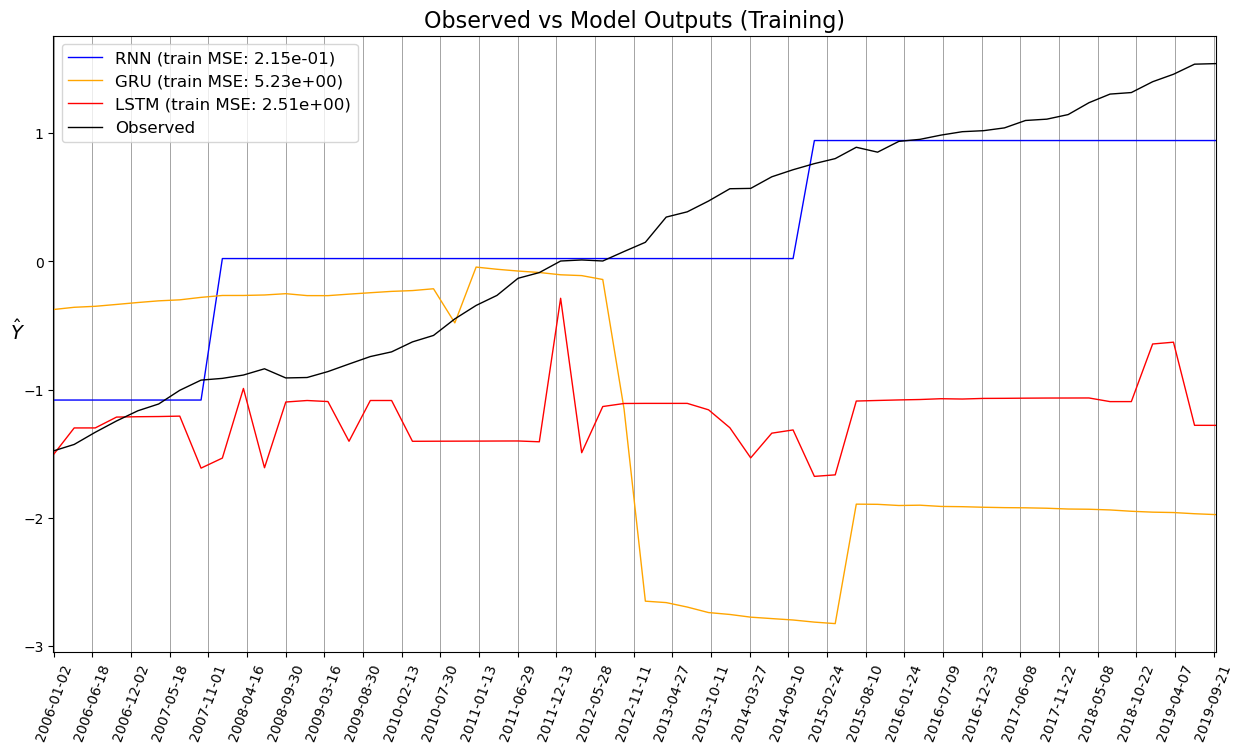

In [75]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

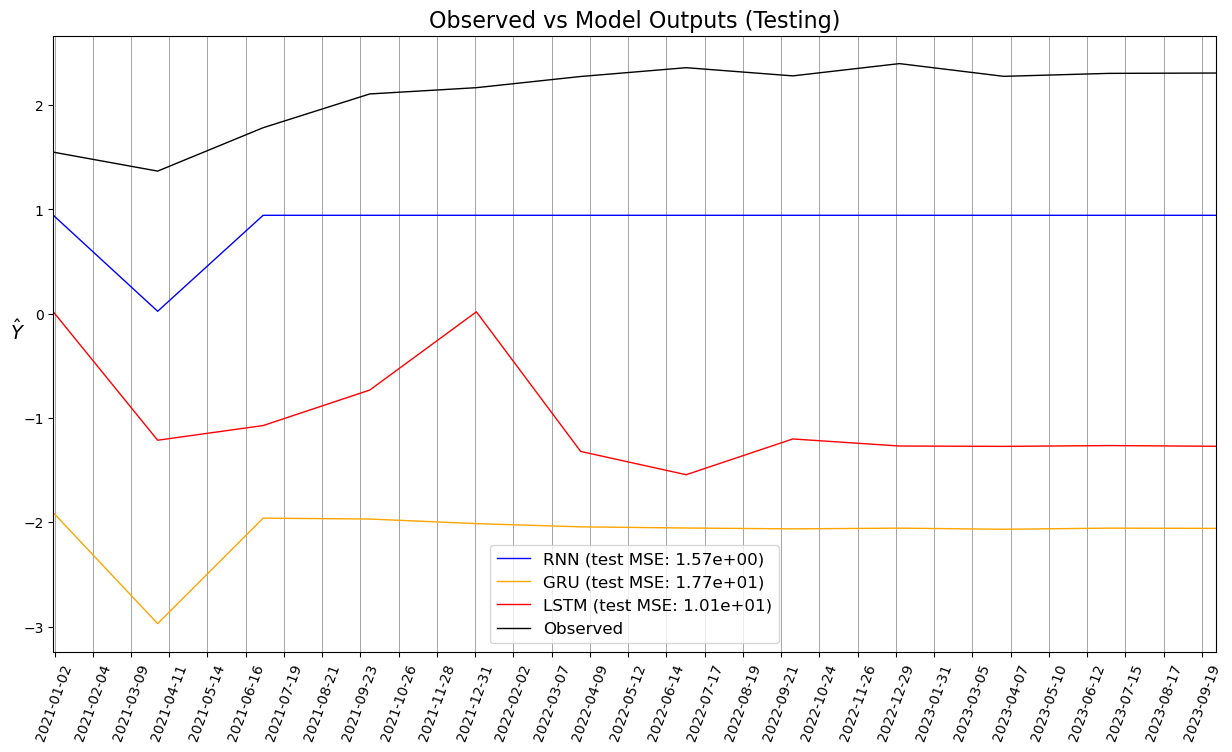

In [76]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

In [77]:
params['lstm']['MSE_train']

2.5129434455319104